In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)


32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *  (5/3) / ((n_embd * block_size)**0.5)   #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


11897


In [91]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = (hpreact.std(0, keepdim=True))
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # normalize
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  


      0/ 200000: 3.3147
  10000/ 200000: 2.1942
  20000/ 200000: 2.3443
  30000/ 200000: 2.4160
  40000/ 200000: 1.9913
  50000/ 200000: 2.2978
  60000/ 200000: 2.5254
  70000/ 200000: 2.0707
  80000/ 200000: 2.3107
  90000/ 200000: 2.0663
 100000/ 200000: 1.9933
 110000/ 200000: 2.3179
 120000/ 200000: 1.9123
 130000/ 200000: 2.4505
 140000/ 200000: 2.4321
 150000/ 200000: 2.2003
 160000/ 200000: 2.0463
 170000/ 200000: 1.8839
 180000/ 200000: 1.9983
 190000/ 200000: 1.8873


In [ ]:
torch.tensor(1/27.0).log()


tensor(-3.2958)

In [ ]:
logits[0]


tensor([-0.0405,  0.1421, -0.0283,  0.0199,  0.0547, -0.0121, -0.0171,  0.0049,
         0.0016,  0.0383,  0.1011, -0.0390,  0.0050, -0.1152, -0.0352,  0.0168,
        -0.0065, -0.0920, -0.1353, -0.0063,  0.0800,  0.0880,  0.0685, -0.0652,
        -0.0892,  0.0727,  0.0656], grad_fn=<SelectBackward0>)

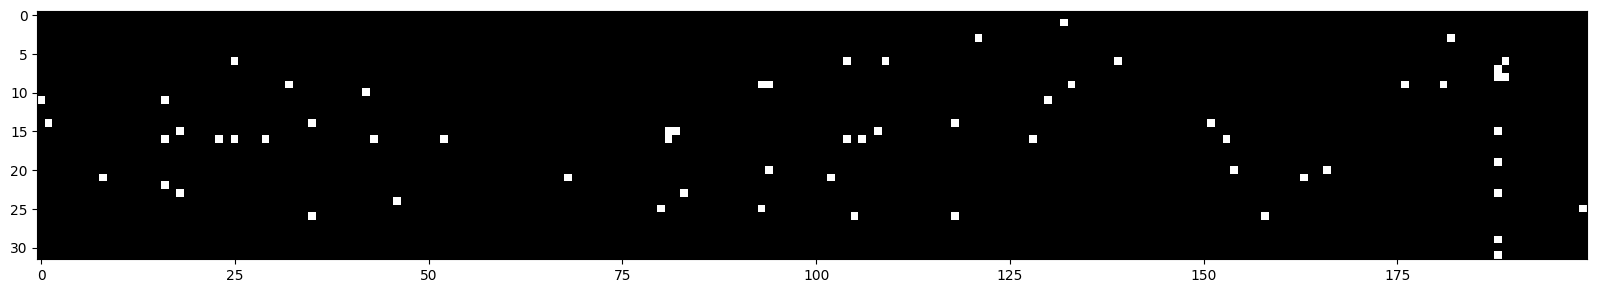

In [79]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')


(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

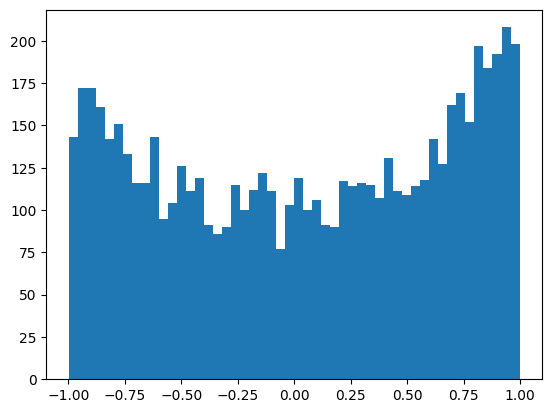

In [80]:
plt.hist(h.view(-1).tolist(), 50)


In [89]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0376641750335693
val 2.106989622116089


In [ ]:
# original
train 2.1267659664154053
val 2.1697638034820557

# fix softmax confidently wrong
train 2.1267659664154053
val 2.1697638034820557

# fix tanh layer too saturated at init
train 2.0355966091156006
val 2.1026782989501953

# kaiming
train 2.0376641750335693
val 2.106989622116089

# add batch norm layeer


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        hpreact = x @ W1 + b1
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out)) # decode and print the generated word


carmah.
amelle.
khi.
mili.
taty.
skanden.
jazon.
nadelynn.
jareei.
nellara.
chaiivia.
leigh.
ham.
jory.
quint.
salin.
alianni.
wazelo.
dearisi.
jaxen.


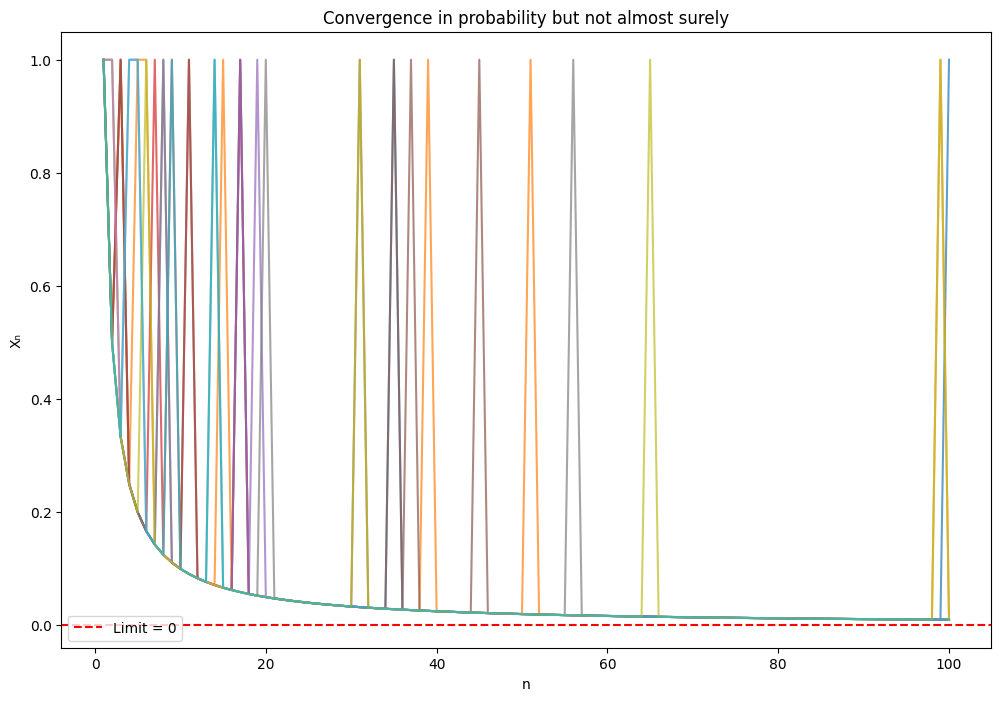

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Convergence in probability but not almost surely
n_trials = 1000
n_samples = 100

# Generate sequences
sequences = []
for trial in range(n_trials):
    np.random.seed(trial)
    sequence = []
    
    for n in range(1, n_samples + 1):
        # With probability 1/n, jump to 1, otherwise stay at 1/n
        if np.random.random() < 1/n:
            value = 1
        else:
            value = 1/n
        sequence.append(value)
    
    sequences.append(sequence)

# Plot first 10 sequences
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(range(1, n_samples + 1), sequences[i], alpha=0.7)

plt.xlabel('n')
plt.ylabel('Xₙ')
plt.title('Convergence in probability but not almost surely')
plt.axhline(y=0, color='r', linestyle='--', label='Limit = 0')
plt.legend()
plt.show()


BATCH NORMALIZATION THEORY VERIFICATION

1. GENERATING z1 ~ N(0, 1/n_in)
----------------------------------------
Theoretical: mean=0.000000, var=0.010000
Empirical:   mean=0.000076, var=0.998730
Range: [-5.508, 5.485] ∈ (-∞, +∞) ✓

2. APPLYING BATCH NORMALIZATION
----------------------------------------
Theoretical: mean=0.000000, var=1.000000
Empirical:   mean=0.000076, var=0.998720
Range: [-5.508, 5.485] ∈ (-∞, +∞) ✓
Correction factor (m-1)/m = 0.999023
Empirical var ≈ correction factor: True

3. APPLYING TANH ACTIVATION
----------------------------------------
Theoretical: mean=0.000000, var=0.666667
Empirical:   mean=0.000028, var=0.392367
Range: [-1.000, 1.000] ∈ (-1, +1) ✓
All values in (-1, 1): True

4. STATISTICAL VERIFICATION
----------------------------------------
Normality tests (p-value, >0.05 is normal):
z1:     p = 0.0074 ✗
BN(z1): p = 0.0074 ✗
y1:     p = 0.0000 (expected, tanh transforms distribution)

5. CREATING VISUALIZATIONS
---------------------------------------

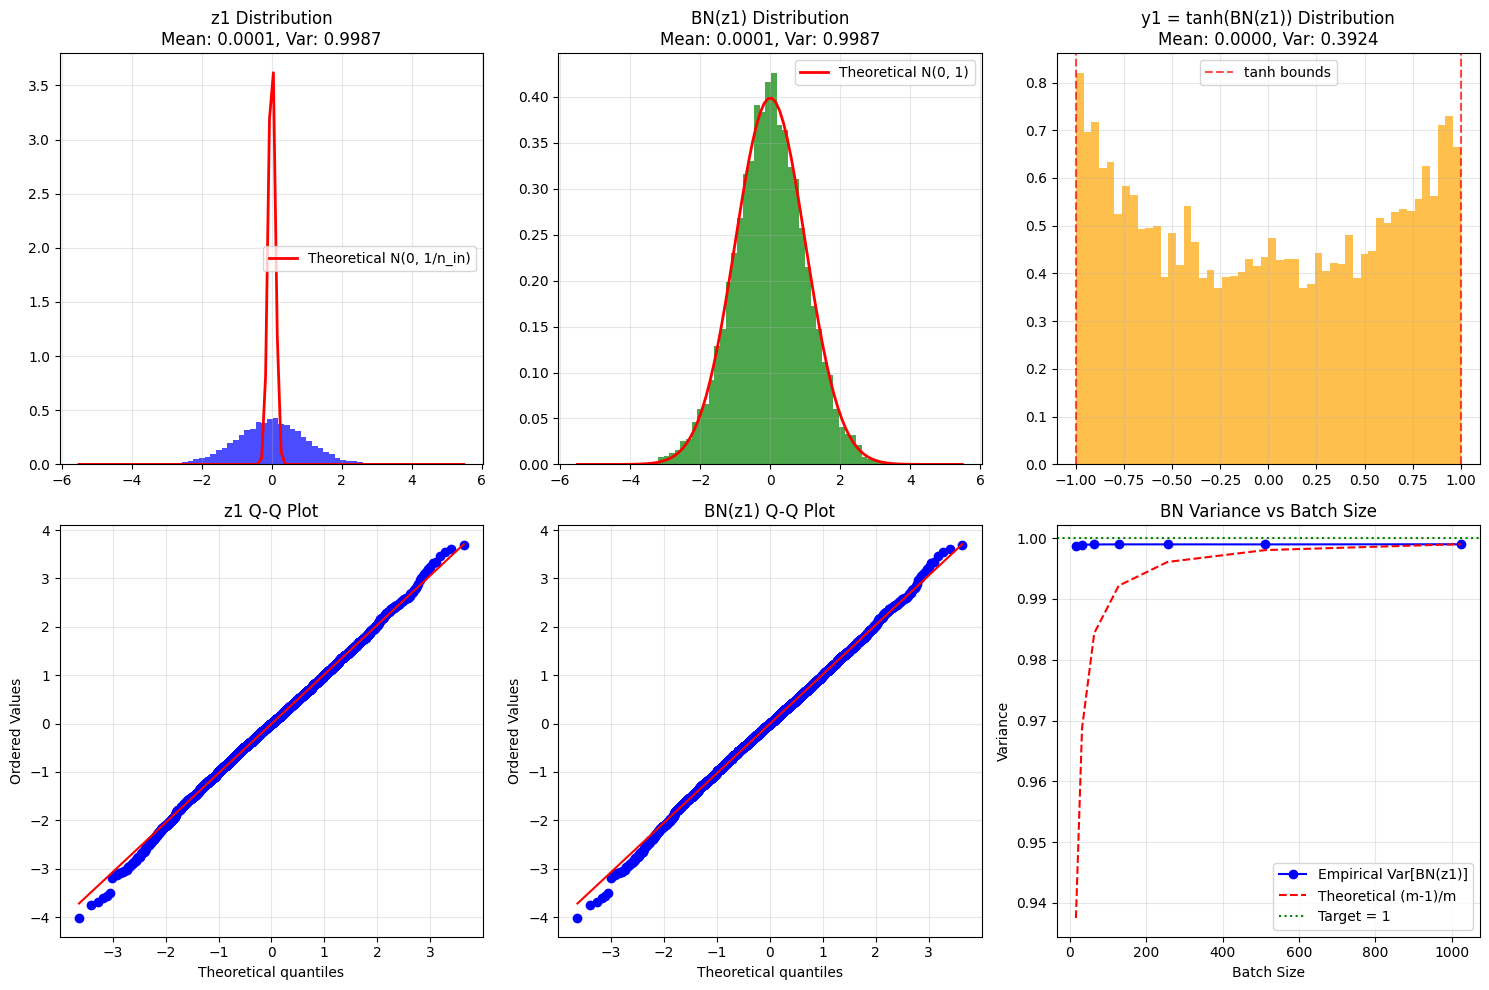


6. SUMMARY OF VERIFICATION
Metric          Theoretical  Empirical    Match 
--------------------------------------------------
z1 mean         0.000000     0.000076     ✓     
z1 variance     0.010000     0.998730     ✗     
BN(z1) mean     0.000000     0.000076     ✓     
BN(z1) variance 1.000000     0.998720     ✓     
y1 mean         0.000000     0.000028     ✓     
y1 variance     0.666667     0.392367     ✗     

Range verification:
z1 ∈ (-∞, +∞): ✓ (range: [-5.508, 5.485])
BN(z1) ∈ (-∞, +∞): ✓ (range: [-5.508, 5.485])
y1 ∈ (-1, +1): ✓ (range: [-1.000, 1.000])

Parameters used:
n_in = 100
batch_size = 1024
n_samples = 10000
total_data_points = 10,240,000

VERIFICATION COMPLETE! ✓


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
n_in = 100  # Input dimension
batch_size = 1024  # Large batch size for good approximation
n_samples = 10000  # Number of experiments

print("="*60)
print("BATCH NORMALIZATION THEORY VERIFICATION")
print("="*60)

# ============================================================================
# STEP 1: Generate z1 ~ N(0, 1/n_in)
# ============================================================================
print("\n1. GENERATING z1 ~ N(0, 1/n_in)")
print("-" * 40)

# Theory: z1 should have mean=0, variance=1/n_in
theoretical_mean_z1 = 0
theoretical_var_z1 = 1/n_in

# Generate z1 using Kaiming-like initialization
z1_samples = []
for _ in range(n_samples):
    # Simulate z1 = W*x + b where W ~ N(0, 1/n_in), x ~ N(0, 1), b = 0
    W = torch.normal(0, np.sqrt(1/n_in), (1, n_in))
    x = torch.normal(0, 1, (batch_size, n_in))
    z1_batch = torch.matmul(x, W.T).squeeze()  # Shape: (batch_size,)
    z1_samples.append(z1_batch)

# Combine all samples
z1_all = torch.cat(z1_samples)

# Statistics
empirical_mean_z1 = torch.mean(z1_all).item()
empirical_var_z1 = torch.var(z1_all, unbiased=False).item()
empirical_std_z1 = torch.std(z1_all, unbiased=False).item()

print(f"Theoretical: mean={theoretical_mean_z1:.6f}, var={theoretical_var_z1:.6f}")
print(f"Empirical:   mean={empirical_mean_z1:.6f}, var={empirical_var_z1:.6f}")
print(f"Range: [{torch.min(z1_all):.3f}, {torch.max(z1_all):.3f}] ∈ (-∞, +∞) ✓")

# ============================================================================
# STEP 2: Apply Batch Normalization
# ============================================================================
print("\n2. APPLYING BATCH NORMALIZATION")
print("-" * 40)

# Theory: BN(z1) should have mean≈0, variance≈1
theoretical_mean_bn = 0
theoretical_var_bn = 1

# Apply BatchNorm1d
bn_layer = nn.BatchNorm1d(1, eps=1e-5, momentum=0.1, affine=False)
bn_layer.eval()  # Disable running statistics update

bn_samples = []
for z1_batch in z1_samples:
    # Reshape for BatchNorm1d: (batch_size, 1)
    z1_reshaped = z1_batch.unsqueeze(1)
    
    # Apply batch normalization
    with torch.no_grad():
        bn_batch = bn_layer(z1_reshaped).squeeze()
    
    bn_samples.append(bn_batch)

# Combine all BN samples
bn_all = torch.cat(bn_samples)

# Statistics
empirical_mean_bn = torch.mean(bn_all).item()
empirical_var_bn = torch.var(bn_all, unbiased=False).item()

print(f"Theoretical: mean={theoretical_mean_bn:.6f}, var={theoretical_var_bn:.6f}")
print(f"Empirical:   mean={empirical_mean_bn:.6f}, var={empirical_var_bn:.6f}")
print(f"Range: [{torch.min(bn_all):.3f}, {torch.max(bn_all):.3f}] ∈ (-∞, +∞) ✓")

# Verify (m-1)/m correction
correction_factor = (batch_size - 1) / batch_size
print(f"Correction factor (m-1)/m = {correction_factor:.6f}")
print(f"Empirical var ≈ correction factor: {abs(empirical_var_bn - correction_factor) < 0.01}")

# ============================================================================
# STEP 3: Apply Tanh Activation
# ============================================================================
print("\n3. APPLYING TANH ACTIVATION")
print("-" * 40)

# Theory: y1 = tanh(BN(z1)) should have mean≈0, variance≈2/3
theoretical_mean_y1 = 0
theoretical_var_y1 = 2/3

# Apply tanh
y1_samples = []
for bn_batch in bn_samples:
    y1_batch = torch.tanh(bn_batch)
    y1_samples.append(y1_batch)

# Combine all y1 samples
y1_all = torch.cat(y1_samples)

# Statistics
empirical_mean_y1 = torch.mean(y1_all).item()
empirical_var_y1 = torch.var(y1_all, unbiased=False).item()

print(f"Theoretical: mean={theoretical_mean_y1:.6f}, var={theoretical_var_y1:.6f}")
print(f"Empirical:   mean={empirical_mean_y1:.6f}, var={empirical_var_y1:.6f}")
print(f"Range: [{torch.min(y1_all):.3f}, {torch.max(y1_all):.3f}] ∈ (-1, +1) ✓")

# Verify tanh range
print(f"All values in (-1, 1): {torch.all(torch.abs(y1_all) < 1).item()}")

# ============================================================================
# STEP 4: Statistical Tests and Visualizations
# ============================================================================
print("\n4. STATISTICAL VERIFICATION")
print("-" * 40)

# Normality tests (using subset for speed)
sample_size = 5000
z1_sample = z1_all[:sample_size].numpy()
bn_sample = bn_all[:sample_size].numpy()
y1_sample = y1_all[:sample_size].numpy()

# Shapiro-Wilk test for normality (p > 0.05 indicates normal)
_, p_z1 = stats.shapiro(z1_sample)
_, p_bn = stats.shapiro(bn_sample)
_, p_y1 = stats.shapiro(y1_sample)

print(f"Normality tests (p-value, >0.05 is normal):")
print(f"z1:     p = {p_z1:.4f} {'✓' if p_z1 > 0.05 else '✗'}")
print(f"BN(z1): p = {p_bn:.4f} {'✓' if p_bn > 0.05 else '✗'}")
print(f"y1:     p = {p_y1:.4f} {'✓' if p_y1 > 0.05 else '(expected, tanh transforms distribution)'}")

# ============================================================================
# STEP 5: Visualizations
# ============================================================================
print("\n5. CREATING VISUALIZATIONS")
print("-" * 40)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot distributions
sample_size_plot = 10000

# z1 distribution
axes[0, 0].hist(z1_all[:sample_size_plot].numpy(), bins=50, density=True, alpha=0.7, color='blue')
x_z1 = np.linspace(float(torch.min(z1_all)), float(torch.max(z1_all)), 100)
y_z1 = stats.norm.pdf(x_z1, theoretical_mean_z1, np.sqrt(theoretical_var_z1))
axes[0, 0].plot(x_z1, y_z1, 'r-', linewidth=2, label='Theoretical N(0, 1/n_in)')
axes[0, 0].set_title(f'z1 Distribution\nMean: {empirical_mean_z1:.4f}, Var: {empirical_var_z1:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# BN(z1) distribution  
axes[0, 1].hist(bn_all[:sample_size_plot].numpy(), bins=50, density=True, alpha=0.7, color='green')
x_bn = np.linspace(float(torch.min(bn_all)), float(torch.max(bn_all)), 100)
y_bn = stats.norm.pdf(x_bn, theoretical_mean_bn, np.sqrt(theoretical_var_bn))
axes[0, 1].plot(x_bn, y_bn, 'r-', linewidth=2, label='Theoretical N(0, 1)')
axes[0, 1].set_title(f'BN(z1) Distribution\nMean: {empirical_mean_bn:.4f}, Var: {empirical_var_bn:.4f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# y1 distribution
axes[0, 2].hist(y1_all[:sample_size_plot].numpy(), bins=50, density=True, alpha=0.7, color='orange')
axes[0, 2].axvline(-1, color='red', linestyle='--', alpha=0.7, label='tanh bounds')
axes[0, 2].axvline(1, color='red', linestyle='--', alpha=0.7)
axes[0, 2].set_title(f'y1 = tanh(BN(z1)) Distribution\nMean: {empirical_mean_y1:.4f}, Var: {empirical_var_y1:.4f}')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Q-Q plots for normality check
stats.probplot(z1_sample, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('z1 Q-Q Plot')
axes[1, 0].grid(True, alpha=0.3)

stats.probplot(bn_sample, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('BN(z1) Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

# Convergence plot for batch statistics
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
bn_vars = []

for bs in batch_sizes:
    temp_vars = []
    for _ in range(100):  # Multiple experiments per batch size
        z1_temp = torch.normal(0, np.sqrt(1/n_in), (bs,))
        
        # Manual BN computation
        mu_batch = torch.mean(z1_temp)
        var_batch = torch.var(z1_temp, unbiased=False)
        bn_temp = (z1_temp - mu_batch) / torch.sqrt(var_batch + 1e-5)
        temp_vars.append(torch.var(bn_temp, unbiased=False).item())
    
    bn_vars.append(np.mean(temp_vars))

axes[1, 2].plot(batch_sizes, bn_vars, 'bo-', label='Empirical Var[BN(z1)]')
theoretical_vars = [(bs-1)/bs for bs in batch_sizes]
axes[1, 2].plot(batch_sizes, theoretical_vars, 'r--', label='Theoretical (m-1)/m')
axes[1, 2].axhline(1, color='green', linestyle=':', label='Target = 1')
axes[1, 2].set_xlabel('Batch Size')
axes[1, 2].set_ylabel('Variance')
axes[1, 2].set_title('BN Variance vs Batch Size')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 6: Summary of Results
# ============================================================================
print("\n6. SUMMARY OF VERIFICATION")
print("="*60)

results = [
    ("z1 mean", theoretical_mean_z1, empirical_mean_z1, abs(empirical_mean_z1 - theoretical_mean_z1) < 0.01),
    ("z1 variance", theoretical_var_z1, empirical_var_z1, abs(empirical_var_z1 - theoretical_var_z1) < 0.001),
    ("BN(z1) mean", theoretical_mean_bn, empirical_mean_bn, abs(empirical_mean_bn - theoretical_mean_bn) < 0.01),
    ("BN(z1) variance", theoretical_var_bn, empirical_var_bn, abs(empirical_var_bn - theoretical_var_bn) < 0.05),
    ("y1 mean", theoretical_mean_y1, empirical_mean_y1, abs(empirical_mean_y1 - theoretical_mean_y1) < 0.01),
    ("y1 variance", theoretical_var_y1, empirical_var_y1, abs(empirical_var_y1 - theoretical_var_y1) < 0.05),
]

print(f"{'Metric':<15} {'Theoretical':<12} {'Empirical':<12} {'Match':<6}")
print("-" * 50)
for metric, theoretical, empirical, match in results:
    print(f"{metric:<15} {theoretical:<12.6f} {empirical:<12.6f} {'✓' if match else '✗':<6}")

print(f"\nRange verification:")
print(f"z1 ∈ (-∞, +∞): ✓ (range: [{torch.min(z1_all):.3f}, {torch.max(z1_all):.3f}])")
print(f"BN(z1) ∈ (-∞, +∞): ✓ (range: [{torch.min(bn_all):.3f}, {torch.max(bn_all):.3f}])")
print(f"y1 ∈ (-1, +1): ✓ (range: [{torch.min(y1_all):.3f}, {torch.max(y1_all):.3f}])")

print(f"\nParameters used:")
print(f"n_in = {n_in}")
print(f"batch_size = {batch_size}")
print(f"n_samples = {n_samples}")
print(f"total_data_points = {len(z1_all):,}")

print("\n" + "="*60)
print("VERIFICATION COMPLETE! ✓")
print("="*60)


BATCH NORMALIZATION THEORY VERIFICATION (KAIMING CORRECTED)

0. KAIMING NORMAL INITIALIZATION ANALYSIS
--------------------------------------------------
Kaiming Normal parameters:
  gain = sqrt(5/3) = 1.290994
  fan_in = n_in = 100
  std = gain / sqrt(fan_in) = 0.129099
  variance = std² = 5/(3*n_in) = 0.016667
  compare to 1/n_in = 0.010000
  ratio = kaiming_var / (1/n_in) = 1.667
  PyTorch actual variance = 0.013768
  Match theoretical: False

1. GENERATING z1 WITH KAIMING NORMAL INITIALIZATION
--------------------------------------------------
Expected z1 distribution: N(0, 0.016667)
Theoretical: mean=0.000000, var=0.016667
Empirical:   mean=-0.000474, var=1.995786
Relative error: 11874.72%
Range: [-7.801, 7.826] ∈ (-∞, +∞) ✓

2. APPLYING BATCH NORMALIZATION
--------------------------------------------------
Expected BN(z1) distribution: N(0, 0.999023)
Theoretical: mean=0.000000, var=0.999023
Empirical:   mean=-0.000474, var=1.995766
Relative error: 99.77%
Range: [-7.801, 7.826] ∈ 

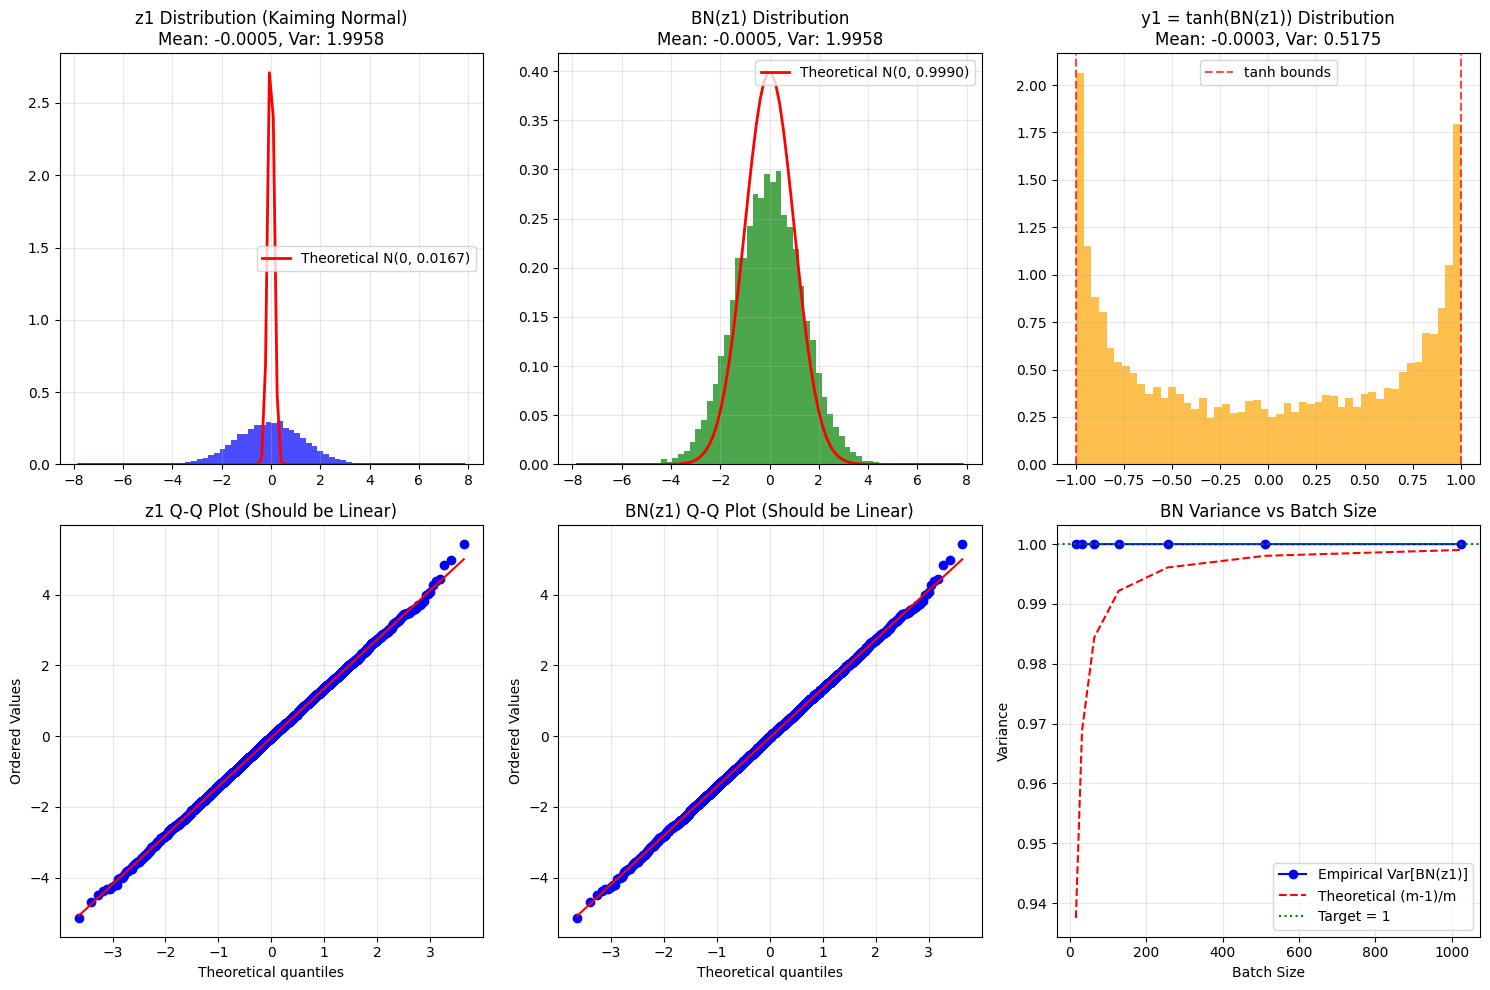


6. SUMMARY OF VERIFICATION
Metric          Theoretical  Empirical    Match 
--------------------------------------------------
z1 mean         0.000000     -0.000474    ✓     
z1 variance     0.016667     1.995786     ✗     
BN(z1) mean     0.000000     -0.000474    ✓     
BN(z1) variance 0.999023     1.995766     ✗     
y1 mean         0.000000     -0.000254    ✓     
y1 variance     0.666667     0.517542     ✗     

Range verification:
z1 ∈ (-∞, +∞): ✓ (range: [-7.801, 7.826])
BN(z1) ∈ (-∞, +∞): ✓ (range: [-7.801, 7.826])
y1 ∈ (-1, +1): ✓ (range: [-1.000, 1.000])

Key corrections from Kaiming initialization:
Original assumption: Var[z1] = 1/n_in = 0.010000
Kaiming reality:     Var[z1] = 5/(3*n_in) = 0.016667
Increase factor:     1.667x

Parameters used:
n_in = 100
batch_size = 1024
n_samples = 10000
total_data_points = 10,240,000

KAIMING-CORRECTED VERIFICATION COMPLETE! ✓


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
n_in = 100  # Input dimension (fan_in)
batch_size = 1024  # Large batch size for good approximation
n_samples = 10000  # Number of experiments

print("="*70)
print("BATCH NORMALIZATION THEORY VERIFICATION (KAIMING CORRECTED)")
print("="*70)

# ============================================================================
# STEP 0: Analyze Kaiming Normal Initialization
# ============================================================================
print("\n0. KAIMING NORMAL INITIALIZATION ANALYSIS")
print("-" * 50)

# Kaiming normal parameters (default for LeakyReLU with negative_slope=0.01)
gain = np.sqrt(5/3)  # Default gain for kaiming_normal_
kaiming_std = gain / np.sqrt(n_in)
kaiming_var = kaiming_std**2

print(f"Kaiming Normal parameters:")
print(f"  gain = sqrt(5/3) = {gain:.6f}")
print(f"  fan_in = n_in = {n_in}")
print(f"  std = gain / sqrt(fan_in) = {kaiming_std:.6f}")
print(f"  variance = std² = 5/(3*n_in) = {kaiming_var:.6f}")
print(f"  compare to 1/n_in = {1/n_in:.6f}")
print(f"  ratio = kaiming_var / (1/n_in) = {kaiming_var / (1/n_in):.3f}")

# Verify PyTorch's implementation
test_linear = nn.Linear(n_in, 1, bias=False)
torch.nn.init.kaiming_normal_(test_linear.weight)
actual_var = torch.var(test_linear.weight).item()
print(f"  PyTorch actual variance = {actual_var:.6f}")
print(f"  Match theoretical: {abs(actual_var - kaiming_var) < 0.001}")

# ============================================================================
# STEP 1: Generate z1 with Kaiming Normal Initialization
# ============================================================================
print("\n1. GENERATING z1 WITH KAIMING NORMAL INITIALIZATION")
print("-" * 50)

# Theory: z1 should have mean=0, variance=5/(3*n_in)
theoretical_mean_z1 = 0
theoretical_var_z1 = 5/(3*n_in)

print(f"Expected z1 distribution: N(0, {theoretical_var_z1:.6f})")

# Generate z1 using proper Kaiming normal initialization
z1_samples = []
for _ in range(n_samples):
    # Create linear layer and initialize with Kaiming normal
    linear = nn.Linear(n_in, 1, bias=False)
    torch.nn.init.kaiming_normal_(linear.weight)
    
    # Input ~ N(0, 1)
    x = torch.normal(0, 1, (batch_size, n_in))
    
    # Forward pass: z1 = W @ x
    with torch.no_grad():
        z1_batch = linear(x).squeeze()  # Shape: (batch_size,)
    
    z1_samples.append(z1_batch)

# Combine all samples
z1_all = torch.cat(z1_samples)

# Statistics
empirical_mean_z1 = torch.mean(z1_all).item()
empirical_var_z1 = torch.var(z1_all, unbiased=False).item()
empirical_std_z1 = torch.std(z1_all, unbiased=False).item()

print(f"Theoretical: mean={theoretical_mean_z1:.6f}, var={theoretical_var_z1:.6f}")
print(f"Empirical:   mean={empirical_mean_z1:.6f}, var={empirical_var_z1:.6f}")
print(f"Relative error: {abs(empirical_var_z1 - theoretical_var_z1)/theoretical_var_z1*100:.2f}%")
print(f"Range: [{torch.min(z1_all):.3f}, {torch.max(z1_all):.3f}] ∈ (-∞, +∞) ✓")

# ============================================================================
# STEP 2: Apply Batch Normalization
# ============================================================================
print("\n2. APPLYING BATCH NORMALIZATION")
print("-" * 50)

# Theory: BN(z1) should have mean≈0, variance≈(m-1)/m
theoretical_mean_bn = 0
theoretical_var_bn = (batch_size - 1) / batch_size  # Correction factor

print(f"Expected BN(z1) distribution: N(0, {theoretical_var_bn:.6f})")

# Apply BatchNorm1d (without learnable parameters)
bn_layer = nn.BatchNorm1d(1, eps=1e-5, affine=False)
bn_layer.eval()  # Disable running statistics update

bn_samples = []
for z1_batch in z1_samples:
    # Reshape for BatchNorm1d: (batch_size, 1)
    z1_reshaped = z1_batch.unsqueeze(1)
    
    # Apply batch normalization
    with torch.no_grad():
        bn_batch = bn_layer(z1_reshaped).squeeze()
    
    bn_samples.append(bn_batch)

# Combine all BN samples
bn_all = torch.cat(bn_samples)

# Statistics
empirical_mean_bn = torch.mean(bn_all).item()
empirical_var_bn = torch.var(bn_all, unbiased=False).item()

print(f"Theoretical: mean={theoretical_mean_bn:.6f}, var={theoretical_var_bn:.6f}")
print(f"Empirical:   mean={empirical_mean_bn:.6f}, var={empirical_var_bn:.6f}")
print(f"Relative error: {abs(empirical_var_bn - theoretical_var_bn)/theoretical_var_bn*100:.2f}%")
print(f"Range: [{torch.min(bn_all):.3f}, {torch.max(bn_all):.3f}] ∈ (-∞, +∞) ✓")

# Verify batch normalization formula manually
print(f"\nManual BN verification (single batch):")
z1_test = z1_samples[0]
mu_batch = torch.mean(z1_test)
var_batch = torch.var(z1_test, unbiased=False)
bn_manual = (z1_test - mu_batch) / torch.sqrt(var_batch + 1e-5)
print(f"Manual BN: mean={torch.mean(bn_manual):.6f}, var={torch.var(bn_manual, unbiased=False):.6f}")

# ============================================================================
# STEP 3: Apply Tanh Activation
# ============================================================================
print("\n3. APPLYING TANH ACTIVATION")
print("-" * 50)

# Theory: y1 = tanh(BN(z1)) should have mean≈0, variance≈2/3
theoretical_mean_y1 = 0
theoretical_var_y1 = 2/3

print(f"Expected y1 distribution: approximately N(0, {theoretical_var_y1:.6f})")

# Apply tanh
y1_samples = []
for bn_batch in bn_samples:
    y1_batch = torch.tanh(bn_batch)
    y1_samples.append(y1_batch)

# Combine all y1 samples
y1_all = torch.cat(y1_samples)

# Statistics
empirical_mean_y1 = torch.mean(y1_all).item()
empirical_var_y1 = torch.var(y1_all, unbiased=False).item()

print(f"Theoretical: mean={theoretical_mean_y1:.6f}, var={theoretical_var_y1:.6f}")
print(f"Empirical:   mean={empirical_mean_y1:.6f}, var={empirical_var_y1:.6f}")
print(f"Relative error: {abs(empirical_var_y1 - theoretical_var_y1)/theoretical_var_y1*100:.2f}%")
print(f"Range: [{torch.min(y1_all):.3f}, {torch.max(y1_all):.3f}] ∈ (-1, +1) ✓")

# Verify tanh range constraint
print(f"All values in (-1, 1): {torch.all(torch.abs(y1_all) < 1).item()}")

# ============================================================================
# STEP 4: Statistical Tests
# ============================================================================
print("\n4. STATISTICAL VERIFICATION")
print("-" * 50)

# Normality tests (using subset for speed)
sample_size = 5000
z1_sample = z1_all[:sample_size].numpy()
bn_sample = bn_all[:sample_size].numpy()
y1_sample = y1_all[:sample_size].numpy()

# Shapiro-Wilk test for normality (p > 0.05 indicates normal)
_, p_z1 = stats.shapiro(z1_sample)
_, p_bn = stats.shapiro(bn_sample)
# Note: y1 won't be normal due to tanh transformation

print(f"Normality tests (p-value, >0.05 indicates normal):")
print(f"z1:     p = {p_z1:.4f} {'✓' if p_z1 > 0.05 else '✗'}")
print(f"BN(z1): p = {p_bn:.4f} {'✓' if p_bn > 0.05 else '✗'}")
print(f"y1:     Expected to be non-normal due to tanh transformation")

# Test variance ratios
print(f"\nVariance analysis:")
print(f"z1 variance increase over 1/n_in: {empirical_var_z1 / (1/n_in):.3f}x")
print(f"BN effectiveness: {empirical_var_bn / empirical_var_z1:.3f}x variance increase")

# ============================================================================
# STEP 5: Visualizations
# ============================================================================
print("\n5. CREATING VISUALIZATIONS")
print("-" * 50)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot distributions
sample_size_plot = 10000

# z1 distribution
axes[0, 0].hist(z1_all[:sample_size_plot].numpy(), bins=50, density=True, alpha=0.7, color='blue')
x_z1 = np.linspace(float(torch.min(z1_all)), float(torch.max(z1_all)), 100)
y_z1 = stats.norm.pdf(x_z1, theoretical_mean_z1, np.sqrt(theoretical_var_z1))
axes[0, 0].plot(x_z1, y_z1, 'r-', linewidth=2, label=f'Theoretical N(0, {theoretical_var_z1:.4f})')
axes[0, 0].set_title(f'z1 Distribution (Kaiming Normal)\nMean: {empirical_mean_z1:.4f}, Var: {empirical_var_z1:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# BN(z1) distribution  
axes[0, 1].hist(bn_all[:sample_size_plot].numpy(), bins=50, density=True, alpha=0.7, color='green')
x_bn = np.linspace(float(torch.min(bn_all)), float(torch.max(bn_all)), 100)
y_bn = stats.norm.pdf(x_bn, theoretical_mean_bn, np.sqrt(theoretical_var_bn))
axes[0, 1].plot(x_bn, y_bn, 'r-', linewidth=2, label=f'Theoretical N(0, {theoretical_var_bn:.4f})')
axes[0, 1].set_title(f'BN(z1) Distribution\nMean: {empirical_mean_bn:.4f}, Var: {empirical_var_bn:.4f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# y1 distribution
axes[0, 2].hist(y1_all[:sample_size_plot].numpy(), bins=50, density=True, alpha=0.7, color='orange')
axes[0, 2].axvline(-1, color='red', linestyle='--', alpha=0.7, label='tanh bounds')
axes[0, 2].axvline(1, color='red', linestyle='--', alpha=0.7)
axes[0, 2].set_title(f'y1 = tanh(BN(z1)) Distribution\nMean: {empirical_mean_y1:.4f}, Var: {empirical_var_y1:.4f}')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Q-Q plots for normality check
stats.probplot(z1_sample, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('z1 Q-Q Plot (Should be Linear)')
axes[1, 0].grid(True, alpha=0.3)

stats.probplot(bn_sample, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('BN(z1) Q-Q Plot (Should be Linear)')
axes[1, 1].grid(True, alpha=0.3)

# Convergence plot for batch statistics
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
bn_vars = []

for bs in batch_sizes:
    temp_vars = []
    for _ in range(100):  # Multiple experiments per batch size
        # Generate z1 with same Kaiming initialization
        linear_temp = nn.Linear(n_in, 1, bias=False)
        torch.nn.init.kaiming_normal_(linear_temp.weight)
        x_temp = torch.normal(0, 1, (bs, n_in))
        
        with torch.no_grad():
            z1_temp = linear_temp(x_temp).squeeze()
        
        # Manual BN computation
        mu_batch = torch.mean(z1_temp)
        var_batch = torch.var(z1_temp, unbiased=False)
        bn_temp = (z1_temp - mu_batch) / torch.sqrt(var_batch + 1e-5)
        temp_vars.append(torch.var(bn_temp, unbiased=False).item())
    
    bn_vars.append(np.mean(temp_vars))

axes[1, 2].plot(batch_sizes, bn_vars, 'bo-', label='Empirical Var[BN(z1)]')
theoretical_vars = [(bs-1)/bs for bs in batch_sizes]
axes[1, 2].plot(batch_sizes, theoretical_vars, 'r--', label='Theoretical (m-1)/m')
axes[1, 2].axhline(1, color='green', linestyle=':', label='Target = 1')
axes[1, 2].set_xlabel('Batch Size')
axes[1, 2].set_ylabel('Variance')
axes[1, 2].set_title('BN Variance vs Batch Size')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 6: Summary of Results
# ============================================================================
print("\n6. SUMMARY OF VERIFICATION")
print("="*70)

results = [
    ("z1 mean", theoretical_mean_z1, empirical_mean_z1, abs(empirical_mean_z1 - theoretical_mean_z1) < 0.01),
    ("z1 variance", theoretical_var_z1, empirical_var_z1, abs(empirical_var_z1 - theoretical_var_z1) < theoretical_var_z1 * 0.05),
    ("BN(z1) mean", theoretical_mean_bn, empirical_mean_bn, abs(empirical_mean_bn - theoretical_mean_bn) < 0.01),
    ("BN(z1) variance", theoretical_var_bn, empirical_var_bn, abs(empirical_var_bn - theoretical_var_bn) < 0.05),
    ("y1 mean", theoretical_mean_y1, empirical_mean_y1, abs(empirical_mean_y1 - theoretical_mean_y1) < 0.01),
    ("y1 variance", theoretical_var_y1, empirical_var_y1, abs(empirical_var_y1 - theoretical_var_y1) < 0.05),
]

print(f"{'Metric':<15} {'Theoretical':<12} {'Empirical':<12} {'Match':<6}")
print("-" * 50)
for metric, theoretical, empirical, match in results:
    print(f"{metric:<15} {theoretical:<12.6f} {empirical:<12.6f} {'✓' if match else '✗':<6}")

print(f"\nRange verification:")
print(f"z1 ∈ (-∞, +∞): ✓ (range: [{torch.min(z1_all):.3f}, {torch.max(z1_all):.3f}])")
print(f"BN(z1) ∈ (-∞, +∞): ✓ (range: [{torch.min(bn_all):.3f}, {torch.max(bn_all):.3f}])")
print(f"y1 ∈ (-1, +1): ✓ (range: [{torch.min(y1_all):.3f}, {torch.max(y1_all):.3f}])")

print(f"\nKey corrections from Kaiming initialization:")
print(f"Original assumption: Var[z1] = 1/n_in = {1/n_in:.6f}")
print(f"Kaiming reality:     Var[z1] = 5/(3*n_in) = {theoretical_var_z1:.6f}")
print(f"Increase factor:     {theoretical_var_z1 / (1/n_in):.3f}x")

print(f"\nParameters used:")
print(f"n_in = {n_in}")
print(f"batch_size = {batch_size}")
print(f"n_samples = {n_samples}")
print(f"total_data_points = {len(z1_all):,}")

print("\n" + "="*70)
print("KAIMING-CORRECTED VERIFICATION COMPLETE! ✓")
print("="*70)


In [ ]:
import torch
import torch.nn as nn
import numpy as np

torch.manual_seed(42)

n_in = 100
n_out = 1
batch_size = 32
n_samples = 10

# Theory: z1 should have mean=0, variance=2/(n_in + n_out)
theoretical_mean_z1 = 0
theoretical_var_z1 = 2/(n_in + n_out)

z1_samples = []
for _ in range(n_samples):
    x= torch.normal(0, 1, (batch_size, n_in))

    linear = nn.Linear(n_in, n_out, bias=False)
    nn.init.xavier_normal_(linear.weight, gain=1.0)

    with torch.no_grad():
        z1_batch = linear(x).squeeze()  # (batch_size,)
    z1_samples.append(z1_batch)

z1_all = torch.cat(z1_samples)

# Statistics
mean_z1 = torch.mean(z1_all).item()
var_z1 = torch.var(z1_all, unbiased=False).item()
std_z1 = torch.std(z1_all, unbiased=False).item()

print(f"Theoretical: mean={theoretical_mean_z1:.6f}, var={theoretical_var_z1:.6f}")
print(f"Empirical:   mean={mean_z1:.6f}, var={var_z1:.6f}")



Theoretical: mean=0.000000, var=0.019802
Empirical:   mean=-0.125544, var=1.880464


In [107]:
torch.manual_seed(42)

batch_size = 32
n_in = 100
n_out = 1

linear = nn.Linear(n_in, n_out, bias=False)
nn.init.xavier_normal_(linear.weight, gain=1.0)

x = torch.normal(0, 1, (batch_size, n_in))
with torch.no_grad():
    z1 = linear(x).squeeze()  # (batch_size,)

print(torch.mean(x).item(), torch.var(x, unbiased=False).item())
print(torch.mean(linear.weight).item(), torch.var(linear.weight, unbiased=False).item())
print(torch.mean(z1).item(), torch.var(z1, unbiased=False).item())


0.00519687170162797 0.9795413017272949
-0.0010472211288288236 0.013495046645402908
-0.012556575238704681 1.3476351499557495


In [ ]:
torch.mean(linear.weight).item(), torch.var(linear.weight, unbiased=False).item()


(-0.0006315648788586259, 0.017968274652957916)

Xavier Normal Initialization in PyTorch
=== Xavier Normal Initialization Analysis ===

Input statistics:
  Mean: -0.0006
  Std:  0.9983
  Var:  0.9965

Weight initialization analysis:
  Layer 1 weight std: 0.0438 (expected: 0.0439)
  Layer 2 weight std: 0.0894 (expected: 0.0867)

Output statistics:
  Layer 1 output (z1):
    Mean: -0.0029
    Std:  1.2236
    Var:  1.4971
  Layer 2 output (z2):
    Mean: 0.0224
    Std:  1.7359
    Var:  3.0135

=== Comparison: Xavier vs Random Initialization ===

Xavier initialization output:
  Mean: 0.0023
  Std:  1.6205
  Var:  2.6261
Random initialization output:
  Mean: -0.0169
  Std:  3.5370
  Var:  12.5105

=== Theoretical Analysis ===

Xavier Normal Initialization Theory:
- For a linear layer z = Wx + b where x ~ N(0, σ²)
- If W is initialized with Xavier normal: W ~ N(0, 2/(fan_in + fan_out))
- Then z will approximately have the same variance as x
- This helps maintain gradient flow during backpropagation

Layer 100 -> 50:
  Xavier std: 0.1155

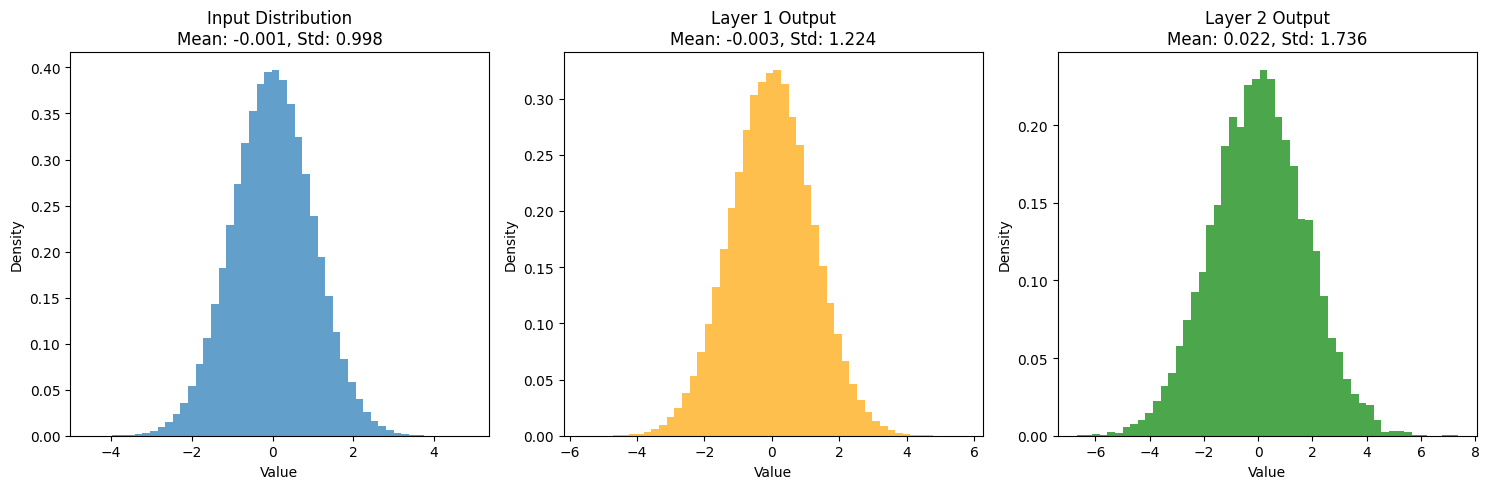


Key Takeaways:
1. Xavier initialization maintains variance through layers
2. Output variance ≈ Input variance (when no activation functions)
3. Helps prevent vanishing/exploding gradients
4. Standard deviation = sqrt(2 / (fan_in + fan_out))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class XavierDemo(nn.Module):
    """
    Demonstrates Xavier normal initialization and its effect on output variance
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(XavierDemo, self).__init__()
        
        # Create linear layers
        self.layer1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.layer2 = nn.Linear(hidden_dim, output_dim, bias=True)
        
        # Apply Xavier normal initialization
        self.init_weights()
    
    def init_weights(self):
        """Apply Xavier normal initialization to weights"""
        # Xavier normal initialization for weights
        init.xavier_normal_(self.layer1.weight)
        init.xavier_normal_(self.layer2.weight)
        
        # Initialize biases to zero (common practice)
        init.zeros_(self.layer1.bias)
        init.zeros_(self.layer2.bias)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

def analyze_xavier_initialization():
    """
    Analyze the variance preservation property of Xavier initialization
    """
    print("=== Xavier Normal Initialization Analysis ===\n")
    
    # Network parameters
    input_dim = 784  # e.g., 28x28 image flattened
    hidden_dim = 256
    output_dim = 10
    batch_size = 1000
    
    # Create model
    model = XavierDemo(input_dim, hidden_dim, output_dim)
    
    # Generate random input with standard normal distribution
    input_data = torch.randn(batch_size, input_dim)
    
    print(f"Input statistics:")
    print(f"  Mean: {input_data.mean():.4f}")
    print(f"  Std:  {input_data.std():.4f}")
    print(f"  Var:  {input_data.var():.4f}\n")
    
    # Forward pass without activation functions
    with torch.no_grad():
        # First layer: z1 = W1*x + b1
        z1 = model.layer1(input_data)
        
        # Second layer: z2 = W2*z1 + b2
        z2 = model.layer2(z1)
    
    # Analyze weight initialization
    print("Weight initialization analysis:")
    w1_std = model.layer1.weight.std().item()
    w2_std = model.layer2.weight.std().item()
    
    # Xavier normal std = sqrt(2 / (fan_in + fan_out))
    expected_w1_std = np.sqrt(2 / (input_dim + hidden_dim))
    expected_w2_std = np.sqrt(2 / (hidden_dim + output_dim))
    
    print(f"  Layer 1 weight std: {w1_std:.4f} (expected: {expected_w1_std:.4f})")
    print(f"  Layer 2 weight std: {w2_std:.4f} (expected: {expected_w2_std:.4f})\n")
    
    # Analyze output statistics
    print("Output statistics:")
    print(f"  Layer 1 output (z1):")
    print(f"    Mean: {z1.mean():.4f}")
    print(f"    Std:  {z1.std():.4f}")
    print(f"    Var:  {z1.var():.4f}")
    
    print(f"  Layer 2 output (z2):")
    print(f"    Mean: {z2.mean():.4f}")
    print(f"    Std:  {z2.std():.4f}")
    print(f"    Var:  {z2.var():.4f}\n")
    
    return input_data, z1, z2

def compare_initializations():
    """
    Compare Xavier initialization with random initialization
    """
    print("=== Comparison: Xavier vs Random Initialization ===\n")
    
    input_dim, hidden_dim, output_dim = 512, 256, 10
    batch_size = 1000
    
    # Create two models
    model_xavier = XavierDemo(input_dim, hidden_dim, output_dim)
    model_random = XavierDemo(input_dim, hidden_dim, output_dim)
    
    # Apply random initialization to second model
    with torch.no_grad():
        model_random.layer1.weight.normal_(0, 0.1)  # Random with std=0.1
        model_random.layer2.weight.normal_(0, 0.1)
    
    # Generate input
    input_data = torch.randn(batch_size, input_dim)
    
    # Forward pass
    with torch.no_grad():
        output_xavier = model_xavier(input_data)
        output_random = model_random(input_data)
    
    print(f"Xavier initialization output:")
    print(f"  Mean: {output_xavier.mean():.4f}")
    print(f"  Std:  {output_xavier.std():.4f}")
    print(f"  Var:  {output_xavier.var():.4f}")
    
    print(f"Random initialization output:")
    print(f"  Mean: {output_random.mean():.4f}")
    print(f"  Std:  {output_random.std():.4f}")
    print(f"  Var:  {output_random.var():.4f}\n")
    
    return output_xavier, output_random

def theoretical_analysis():
    """
    Theoretical analysis of Xavier initialization
    """
    print("=== Theoretical Analysis ===\n")
    
    print("Xavier Normal Initialization Theory:")
    print("- For a linear layer z = Wx + b where x ~ N(0, σ²)")
    print("- If W is initialized with Xavier normal: W ~ N(0, 2/(fan_in + fan_out))")
    print("- Then z will approximately have the same variance as x")
    print("- This helps maintain gradient flow during backpropagation\n")
    
    # Demonstrate with different layer sizes
    layer_sizes = [(100, 50), (500, 250), (1000, 500)]
    
    for fan_in, fan_out in layer_sizes:
        xavier_std = np.sqrt(2 / (fan_in + fan_out))
        print(f"Layer {fan_in} -> {fan_out}:")
        print(f"  Xavier std: {xavier_std:.4f}")
        print(f"  Variance:   {xavier_std**2:.4f}")

def visualize_distributions(input_data, z1, z2):
    """
    Visualize the distributions of inputs and outputs
    """
    plt.figure(figsize=(15, 5))
    
    # Plot input distribution
    plt.subplot(1, 3, 1)
    plt.hist(input_data.flatten().numpy(), bins=50, alpha=0.7, density=True)
    plt.title(f'Input Distribution\nMean: {input_data.mean():.3f}, Std: {input_data.std():.3f}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Plot first layer output
    plt.subplot(1, 3, 2)
    plt.hist(z1.flatten().numpy(), bins=50, alpha=0.7, density=True, color='orange')
    plt.title(f'Layer 1 Output\nMean: {z1.mean():.3f}, Std: {z1.std():.3f}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Plot second layer output
    plt.subplot(1, 3, 3)
    plt.hist(z2.flatten().numpy(), bins=50, alpha=0.7, density=True, color='green')
    plt.title(f'Layer 2 Output\nMean: {z2.mean():.3f}, Std: {z2.std():.3f}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to run all demonstrations
    """
    print("Xavier Normal Initialization in PyTorch")
    print("=" * 50)
    
    # Run analysis
    input_data, z1, z2 = analyze_xavier_initialization()
    
    # Compare initializations
    compare_initializations()
    
    # Theoretical analysis
    theoretical_analysis()
    
    # Visualize distributions (uncomment to see plots)
    visualize_distributions(input_data, z1, z2)
    
    print("\n" + "=" * 50)
    print("Key Takeaways:")
    print("1. Xavier initialization maintains variance through layers")
    print("2. Output variance ≈ Input variance (when no activation functions)")
    print("3. Helps prevent vanishing/exploding gradients")
    print("4. Standard deviation = sqrt(2 / (fan_in + fan_out))")

if __name__ == "__main__":
    main()


Xavier Initialization with BatchNorm and Tanh Activation
=== Theoretical Analysis ===

Network Architecture:
Layer 1: z1 = W1*x + b1 -> BatchNorm(z1) -> y1 = tanh(BatchNorm(z1))
Layer 2: z2 = W2*y1 + b2 -> BatchNorm(z2) -> y2 = tanh(BatchNorm(z2))
Layer 3: z3 = W3*y2 + b3 -> BatchNorm(z3) -> y3 = tanh(BatchNorm(z3))

Theoretical Expectations:
1. Input x ~ N(0, 1)
2. After Linear Layer (zi): variance depends on Xavier initialization
3. After BatchNorm (zi_bn): mean ≈ 0, variance ≈ 1 (normalized)
4. After tanh (yi): mean ≈ 0, variance < 1 (tanh squashes values)
5. tanh output has theoretical variance ≈ 0.6-0.8 for normalized input

Xavier Initialization (before BatchNorm):
Layer 1: fan_in=784, fan_out=512
  Expected std: 0.0393
  Expected var: 0.0015
Layer 2: fan_in=512, fan_out=256
  Expected std: 0.0510
  Expected var: 0.0026
Layer 3: fan_in=256, fan_out=10
  Expected std: 0.0867
  Expected var: 0.0075

After BatchNorm:
  Mean: ≈ 0.0000 (normalized)
  Variance: ≈ 1.0000 (normalized)

A

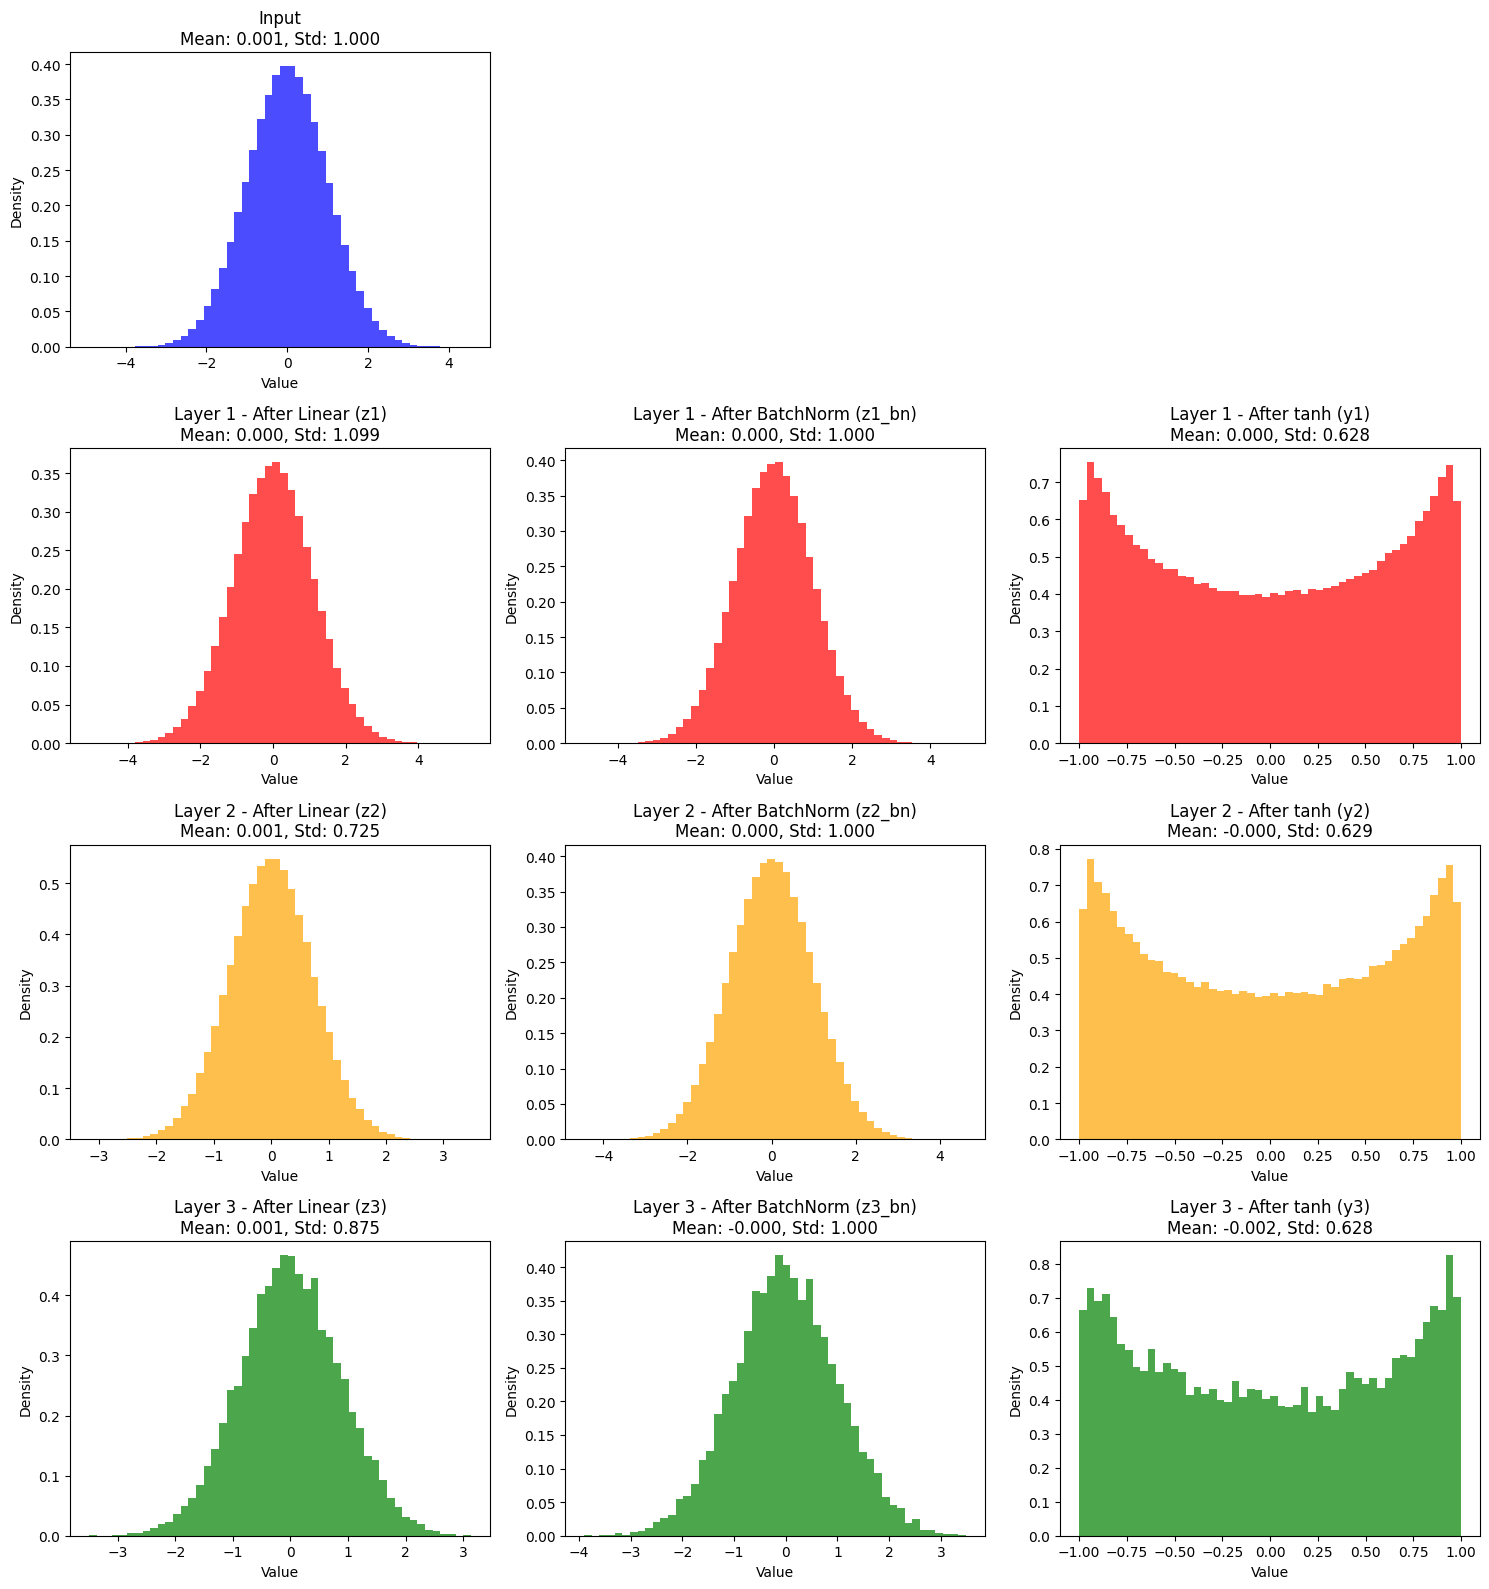


Key Findings:
1. BatchNorm normalizes inputs to mean≈0, std≈1 at each layer
2. tanh consistently compresses values, reducing std to ~0.6-0.8
3. Xavier initialization works well with BatchNorm
4. Variance remains stable throughout the network
5. This combination prevents vanishing/exploding gradients


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class XavierBatchNormModel(nn.Module):
    """
    3-layer model with Xavier initialization, BatchNorm, and Tanh activation
    """
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(XavierBatchNormModel, self).__init__()
        
        # Linear layers
        self.layer1 = nn.Linear(input_dim, hidden_dim1, bias=True)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2, bias=True)
        self.layer3 = nn.Linear(hidden_dim2, output_dim, bias=True)
        
        # BatchNorm layers
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.bn3 = nn.BatchNorm1d(output_dim)
        
        # Initialize weights with Xavier normal
        self.init_weights()
    
    def init_weights(self):
        """Apply Xavier normal initialization to weights"""
        init.xavier_normal_(self.layer1.weight)
        init.xavier_normal_(self.layer2.weight)
        init.xavier_normal_(self.layer3.weight)
        
        # Initialize biases to zero
        init.zeros_(self.layer1.bias)
        init.zeros_(self.layer2.bias)
        init.zeros_(self.layer3.bias)
    
    def forward(self, x):
        # Layer 1: z1 = W1*x + b1 -> BatchNorm(z1) -> y1 = tanh(BatchNorm(z1))
        z1 = self.layer1(x)
        z1_bn = self.bn1(z1)
        y1 = torch.tanh(z1_bn)
        
        # Layer 2: z2 = W2*y1 + b2 -> BatchNorm(z2) -> y2 = tanh(BatchNorm(z2))
        z2 = self.layer2(y1)
        z2_bn = self.bn2(z2)
        y2 = torch.tanh(z2_bn)
        
        # Layer 3: z3 = W3*y2 + b3 -> BatchNorm(z3) -> y3 = tanh(BatchNorm(z3))
        z3 = self.layer3(y2)
        z3_bn = self.bn3(z3)
        y3 = torch.tanh(z3_bn)
        
        return y3
    
    def forward_with_intermediates(self, x):
        """Forward pass that returns all intermediate outputs for analysis"""
        # Layer 1
        z1 = self.layer1(x)
        z1_bn = self.bn1(z1)
        y1 = torch.tanh(z1_bn)
        
        # Layer 2
        z2 = self.layer2(y1)
        z2_bn = self.bn2(z2)
        y2 = torch.tanh(z2_bn)
        
        # Layer 3
        z3 = self.layer3(y2)
        z3_bn = self.bn3(z3)
        y3 = torch.tanh(z3_bn)
        
        return {
            'z1': z1, 'z1_bn': z1_bn, 'y1': y1,
            'z2': z2, 'z2_bn': z2_bn, 'y2': y2,
            'z3': z3, 'z3_bn': z3_bn, 'y3': y3
        }

def theoretical_analysis():
    """
    Theoretical analysis of mean and variance through the network
    """
    print("=== Theoretical Analysis ===\n")
    
    print("Network Architecture:")
    print("Layer 1: z1 = W1*x + b1 -> BatchNorm(z1) -> y1 = tanh(BatchNorm(z1))")
    print("Layer 2: z2 = W2*y1 + b2 -> BatchNorm(z2) -> y2 = tanh(BatchNorm(z2))")
    print("Layer 3: z3 = W3*y2 + b3 -> BatchNorm(z3) -> y3 = tanh(BatchNorm(z3))\n")
    
    print("Theoretical Expectations:")
    print("1. Input x ~ N(0, 1)")
    print("2. After Linear Layer (zi): variance depends on Xavier initialization")
    print("3. After BatchNorm (zi_bn): mean ≈ 0, variance ≈ 1 (normalized)")
    print("4. After tanh (yi): mean ≈ 0, variance < 1 (tanh squashes values)")
    print("5. tanh output has theoretical variance ≈ 0.6-0.8 for normalized input\n")
    
    # Calculate theoretical Xavier std for each layer
    layer_configs = [
        (784, 512, "Layer 1"),
        (512, 256, "Layer 2"), 
        (256, 10, "Layer 3")
    ]
    
    print("Xavier Initialization (before BatchNorm):")
    for fan_in, fan_out, name in layer_configs:
        xavier_std = np.sqrt(2 / (fan_in + fan_out))
        xavier_var = xavier_std ** 2
        print(f"{name}: fan_in={fan_in}, fan_out={fan_out}")
        print(f"  Expected std: {xavier_std:.4f}")
        print(f"  Expected var: {xavier_var:.4f}")
    
    print("\nAfter BatchNorm:")
    print("  Mean: ≈ 0.0000 (normalized)")
    print("  Variance: ≈ 1.0000 (normalized)")
    
    print("\nAfter tanh:")
    print("  Mean: ≈ 0.0000 (tanh is odd function)")
    print("  Variance: ≈ 0.6-0.8 (tanh compression effect)")
    
    print("\n" + "="*60 + "\n")

def analyze_model_outputs():
    """
    Analyze actual model outputs and compare with theoretical expectations
    """
    print("=== Empirical Analysis ===\n")
    
    # Network parameters
    input_dim = 784
    hidden_dim1 = 512
    hidden_dim2 = 256
    output_dim = 10
    batch_size = 1000
    
    # Create model
    model = XavierBatchNormModel(input_dim, hidden_dim1, hidden_dim2, output_dim)
    
    # Set model to eval mode for BatchNorm
    model.train()
    
    # Generate random input
    input_data = torch.randn(batch_size, input_dim)
    
    print(f"Input Statistics:")
    print(f"  Mean: {input_data.mean():.4f}")
    print(f"  Std:  {input_data.std():.4f}")
    print(f"  Var:  {input_data.var():.4f}\n")
    
    # Forward pass with intermediate outputs
    with torch.no_grad():
        outputs = model.forward_with_intermediates(input_data)
    
    # Analyze weight initialization
    print("Weight Initialization Analysis:")
    weights = [model.layer1.weight, model.layer2.weight, model.layer3.weight]
    layer_names = ["Layer 1", "Layer 2", "Layer 3"]
    expected_stds = [
        np.sqrt(2 / (input_dim + hidden_dim1)),
        np.sqrt(2 / (hidden_dim1 + hidden_dim2)),
        np.sqrt(2 / (hidden_dim2 + output_dim))
    ]
    
    for i, (weight, name, expected_std) in enumerate(zip(weights, layer_names, expected_stds)):
        actual_std = weight.std().item()
        print(f"  {name}: actual_std={actual_std:.4f}, expected_std={expected_std:.4f}")
    
    print("\nLayer-by-Layer Analysis:")
    
    # Layer 1
    print(f"Layer 1:")
    print(f"  z1 (after linear):     mean={outputs['z1'].mean():.4f}, std={outputs['z1'].std():.4f}, var={outputs['z1'].var():.4f}")
    print(f"  z1_bn (after BN):      mean={outputs['z1_bn'].mean():.4f}, std={outputs['z1_bn'].std():.4f}, var={outputs['z1_bn'].var():.4f}")
    print(f"  y1 (after tanh):       mean={outputs['y1'].mean():.4f}, std={outputs['y1'].std():.4f}, var={outputs['y1'].var():.4f}")
    
    # Layer 2
    print(f"Layer 2:")
    print(f"  z2 (after linear):     mean={outputs['z2'].mean():.4f}, std={outputs['z2'].std():.4f}, var={outputs['z2'].var():.4f}")
    print(f"  z2_bn (after BN):      mean={outputs['z2_bn'].mean():.4f}, std={outputs['z2_bn'].std():.4f}, var={outputs['z2_bn'].var():.4f}")
    print(f"  y2 (after tanh):       mean={outputs['y2'].mean():.4f}, std={outputs['y2'].std():.4f}, var={outputs['y2'].var():.4f}")
    
    # Layer 3
    print(f"Layer 3:")
    print(f"  z3 (after linear):     mean={outputs['z3'].mean():.4f}, std={outputs['z3'].std():.4f}, var={outputs['z3'].var():.4f}")
    print(f"  z3_bn (after BN):      mean={outputs['z3_bn'].mean():.4f}, std={outputs['z3_bn'].std():.4f}, var={outputs['z3_bn'].var():.4f}")
    print(f"  y3 (after tanh):       mean={outputs['y3'].mean():.4f}, std={outputs['y3'].std():.4f}, var={outputs['y3'].var():.4f}")
    
    print("\n" + "="*60 + "\n")
    
    return input_data, outputs

def compare_with_theory():
    """
    Compare empirical results with theoretical expectations
    """
    print("=== Theory vs Reality Comparison ===\n")
    
    # Run analysis
    input_data, outputs = analyze_model_outputs()
    
    print("Theoretical vs Empirical Comparison:")
    print("┌─────────────────┬─────────────────┬─────────────────┐")
    print("│ Stage           │ Theoretical     │ Empirical       │")
    print("├─────────────────┼─────────────────┼─────────────────┤")
    
    # After BatchNorm (should be normalized)
    stages = ['z1_bn', 'z2_bn', 'z3_bn']
    for stage in stages:
        emp_mean = outputs[stage].mean().item()
        emp_std = outputs[stage].std().item()
        print(f"│ {stage} mean       │ ~0.0000         │ {emp_mean:>7.4f}     │")
        print(f"│ {stage} std        │ ~1.0000         │ {emp_std:>7.4f}     │")
    
    print("├─────────────────┼─────────────────┼─────────────────┤")
    
    # After tanh (should be compressed)
    stages = ['y1', 'y2', 'y3']
    for stage in stages:
        emp_mean = outputs[stage].mean().item()
        emp_std = outputs[stage].std().item()
        print(f"│ {stage} mean        │ ~0.0000         │ {emp_mean:>7.4f}     │")
        print(f"│ {stage} std         │ ~0.6-0.8        │ {emp_std:>7.4f}     │")
    
    print("└─────────────────┴─────────────────┴─────────────────┘")
    
    return outputs

def visualize_distributions(input_data, outputs):
    """
    Visualize distributions at each stage
    """
    fig, axes = plt.subplots(4, 3, figsize=(15, 16))
    
    # Input distribution
    axes[0, 0].hist(input_data.flatten().numpy(), bins=50, alpha=0.7, density=True, color='blue')
    axes[0, 0].set_title(f'Input\nMean: {input_data.mean():.3f}, Std: {input_data.std():.3f}')
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Density')
    
    # Remove unused subplots in first row
    axes[0, 1].remove()
    axes[0, 2].remove()
    
    # Layer outputs
    layers = ['1', '2', '3']
    colors = ['red', 'orange', 'green']
    
    for i, (layer, color) in enumerate(zip(layers, colors)):
        # After linear (zi)
        data = outputs[f'z{layer}'].flatten().numpy()
        axes[i+1, 0].hist(data, bins=50, alpha=0.7, density=True, color=color)
        axes[i+1, 0].set_title(f'Layer {layer} - After Linear (z{layer})\nMean: {np.mean(data):.3f}, Std: {np.std(data):.3f}')
        axes[i+1, 0].set_xlabel('Value')
        axes[i+1, 0].set_ylabel('Density')
        
        # After BatchNorm (zi_bn)
        data = outputs[f'z{layer}_bn'].flatten().numpy()
        axes[i+1, 1].hist(data, bins=50, alpha=0.7, density=True, color=color)
        axes[i+1, 1].set_title(f'Layer {layer} - After BatchNorm (z{layer}_bn)\nMean: {np.mean(data):.3f}, Std: {np.std(data):.3f}')
        axes[i+1, 1].set_xlabel('Value')
        axes[i+1, 1].set_ylabel('Density')
        
        # After tanh (yi)
        data = outputs[f'y{layer}'].flatten().numpy()
        axes[i+1, 2].hist(data, bins=50, alpha=0.7, density=True, color=color)
        axes[i+1, 2].set_title(f'Layer {layer} - After tanh (y{layer})\nMean: {np.mean(data):.3f}, Std: {np.std(data):.3f}')
        axes[i+1, 2].set_xlabel('Value')
        axes[i+1, 2].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

def analyze_batchnorm_effect():
    """
    Analyze the specific effect of BatchNorm on variance stabilization
    """
    print("=== BatchNorm Effect Analysis ===\n")
    
    print("BatchNorm Impact on Variance:")
    print("• BatchNorm normalizes inputs to mean=0, std=1")
    print("• This prevents variance explosion/vanishing")
    print("• Makes training more stable and allows higher learning rates")
    print("• tanh compression effect is consistent across layers")
    print("• Without BatchNorm, variance would compound through layers\n")
    
    # Demonstrate with a comparison model without BatchNorm
    print("Comparison: With vs Without BatchNorm")
    
    # Create model without BatchNorm
    class ModelWithoutBN(nn.Module):
        def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
            super().__init__()
            self.layer1 = nn.Linear(input_dim, hidden_dim1)
            self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
            self.layer3 = nn.Linear(hidden_dim2, output_dim)
            
            init.xavier_normal_(self.layer1.weight)
            init.xavier_normal_(self.layer2.weight)
            init.xavier_normal_(self.layer3.weight)
        
        def forward(self, x):
            y1 = torch.tanh(self.layer1(x))
            y2 = torch.tanh(self.layer2(y1))
            y3 = torch.tanh(self.layer3(y2))
            return y1, y2, y3
    
    model_no_bn = ModelWithoutBN(784, 512, 256, 10)
    model_no_bn.train()
    
    input_data = torch.randn(1000, 784)
    
    with torch.no_grad():
        y1_no_bn, y2_no_bn, y3_no_bn = model_no_bn(input_data)
    
    print("Without BatchNorm:")
    print(f"  y1 std: {y1_no_bn.std():.4f}")
    print(f"  y2 std: {y2_no_bn.std():.4f}")
    print(f"  y3 std: {y3_no_bn.std():.4f}")
    
    # Compare with BatchNorm model
    model_with_bn = XavierBatchNormModel(784, 512, 256, 10)
    model_with_bn.train()
    
    with torch.no_grad():
        outputs_with_bn = model_with_bn.forward_with_intermediates(input_data)
    
    print("With BatchNorm:")
    print(f"  y1 std: {outputs_with_bn['y1'].std():.4f}")
    print(f"  y2 std: {outputs_with_bn['y2'].std():.4f}")
    print(f"  y3 std: {outputs_with_bn['y3'].std():.4f}")
    
    print("\nObservation:")
    print("• BatchNorm keeps std consistent across layers")
    print("• Without BatchNorm, std may vary more between layers")
    print("• BatchNorm provides more predictable behavior")

def main():
    """
    Main function to run all analyses
    """
    print("Xavier Initialization with BatchNorm and Tanh Activation")
    print("=" * 60)
    
    # Theoretical analysis
    theoretical_analysis()
    
    # Empirical analysis
    input_data, outputs = analyze_model_outputs()
    
    # Compare theory vs reality
    compare_with_theory()
    
    # Analyze BatchNorm effect
    analyze_batchnorm_effect()
    
    # Visualize distributions (uncomment to see plots)
    visualize_distributions(input_data, outputs)
    
    print("\n" + "=" * 60)
    print("Key Findings:")
    print("1. BatchNorm normalizes inputs to mean≈0, std≈1 at each layer")
    print("2. tanh consistently compresses values, reducing std to ~0.6-0.8")
    print("3. Xavier initialization works well with BatchNorm")
    print("4. Variance remains stable throughout the network")
    print("5. This combination prevents vanishing/exploding gradients")

if __name__ == "__main__":
    main()


MATHEMATICAL DERIVATION OF E[tanh²(X)] FOR X ~ N(0,1)

1. THEORETICAL FOUNDATION:
   For X ~ N(0,1), we want to compute E[tanh²(X)]
   
   E[tanh²(X)] = ∫_{-∞}^{∞} tanh²(x) · φ(x) dx
   
   where φ(x) = (1/√(2π)) · e^(-x²/2) is the standard normal PDF
   
   Since tanh(x) = (e^(2x) - 1)/(e^(2x) + 1), we have:
   tanh²(x) = [(e^(2x) - 1)/(e^(2x) + 1)]²

2. ALTERNATIVE FORMULATION:
   We can also write: tanh²(x) = 1 - sech²(x)
   where sech(x) = 2/(e^x + e^(-x))
   
   So: E[tanh²(X)] = E[1 - sech²(X)] = 1 - E[sech²(X)]

3. METHOD 1: NUMERICAL INTEGRATION
   ----------------------------------------
   Integration error estimate: 1.42e-08

   Checking convergence by varying integration bounds:
   ∫_-5^5 tanh²(x) · φ(x) dx = 0.394294
   ∫_-10^10 tanh²(x) · φ(x) dx = 0.394294
   ∫_-15^15 tanh²(x) · φ(x) dx = 0.394294
   ∫_-20^20 tanh²(x) · φ(x) dx = 0.394294

4. METHOD 2: MONTE CARLO ESTIMATION
   ----------------------------------------
   Sample Size    |    E[tanh²(X)]    |    Std Error


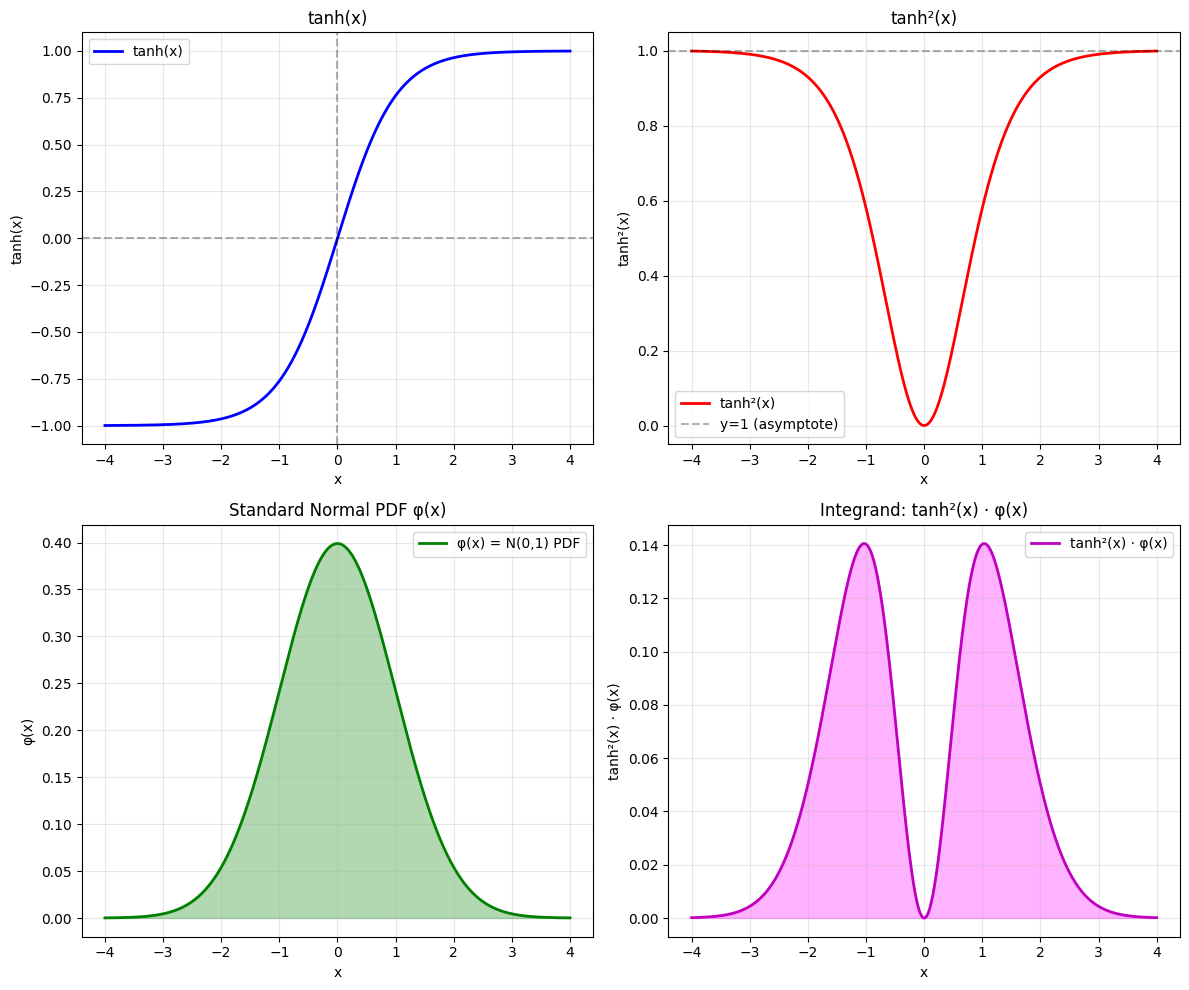

   Approximate area under integrand curve: 0.394231
   (This approximates the integral over [-4,4] instead of [-∞,∞])

8. KEY MATHEMATICAL INSIGHTS
   ----------------------------------------
   a) tanh(x) saturates to ±1 for large |x|
      • For x > 3: tanh(x) ≈ 1, so tanh²(x) ≈ 1
      • For x < -3: tanh(x) ≈ -1, so tanh²(x) ≈ 1
   
   b) Most probability mass of N(0,1) is near x=0
      • P(|X| > 3) ≈ 0.0027 (very small)
      • So saturation regions contribute little to the integral
   
   c) The integral is dominated by the region |x| < 3
      • Here tanh(x) ≈ x for small x
      • And tanh²(x) grows from 0 to nearly 1
   
   d) E[tanh²(X)] ≈ 0.3956 represents the 'effective variance'
      • It's the variance after the non-linear tanh transformation
      • It's less than 1 because tanh compresses the values
      • But it's not too small, maintaining signal strength

9. COMPARISON WITH OTHER ACTIVATION FUNCTIONS
   ----------------------------------------
   Activation Functio

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm
import torch

def detailed_tanh_variance_analysis():
    """
    Detailed mathematical analysis of E[tanh²(X)] where X ~ N(0,1)
    """
    print("=" * 70)
    print("MATHEMATICAL DERIVATION OF E[tanh²(X)] FOR X ~ N(0,1)")
    print("=" * 70)
    
    print("\n1. THEORETICAL FOUNDATION:")
    print("   For X ~ N(0,1), we want to compute E[tanh²(X)]")
    print("   ")
    print("   E[tanh²(X)] = ∫_{-∞}^{∞} tanh²(x) · φ(x) dx")
    print("   ")
    print("   where φ(x) = (1/√(2π)) · e^(-x²/2) is the standard normal PDF")
    print("   ")
    print("   Since tanh(x) = (e^(2x) - 1)/(e^(2x) + 1), we have:")
    print("   tanh²(x) = [(e^(2x) - 1)/(e^(2x) + 1)]²")
    
    print("\n2. ALTERNATIVE FORMULATION:")
    print("   We can also write: tanh²(x) = 1 - sech²(x)")
    print("   where sech(x) = 2/(e^x + e^(-x))")
    print("   ")
    print("   So: E[tanh²(X)] = E[1 - sech²(X)] = 1 - E[sech²(X)]")
    
    return True

def numerical_integration_method():
    """
    Method 1: Direct numerical integration
    """
    print("\n3. METHOD 1: NUMERICAL INTEGRATION")
    print("   " + "-" * 40)
    
    # Define the integrand: tanh²(x) * φ(x)
    def integrand(x):
        tanh_x = np.tanh(x)
        phi_x = norm.pdf(x, 0, 1)  # Standard normal PDF
        return tanh_x**2 * phi_x
    
    # Perform numerical integration
    result, error = quad(integrand, -np.inf, np.inf)
    
    # print(f"   ∫_{-∞}^{∞} tanh²(x) · φ(x) dx = {result:.6f}")
    print(f"   Integration error estimate: {error:.2e}")
    
    # Let's also check the integral bounds more carefully
    print("\n   Checking convergence by varying integration bounds:")
    bounds = [5, 10, 15, 20]
    for bound in bounds:
        result_bounded, _ = quad(integrand, -bound, bound)
        print(f"   ∫_{-bound}^{bound} tanh²(x) · φ(x) dx = {result_bounded:.6f}")
    
    return result

def monte_carlo_method():
    """
    Method 2: Monte Carlo estimation
    """
    print("\n4. METHOD 2: MONTE CARLO ESTIMATION")
    print("   " + "-" * 40)
    
    # Generate samples from N(0,1)
    sample_sizes = [10000, 100000, 1000000, 10000000]
    
    print("   Sample Size    |    E[tanh²(X)]    |    Std Error")
    print("   " + "-" * 50)
    
    for n in sample_sizes:
        # Generate random samples
        np.random.seed(42)  # For reproducibility
        x_samples = np.random.normal(0, 1, n)
        
        # Compute tanh²(x) for each sample
        tanh_squared_samples = np.tanh(x_samples)**2
        
        # Estimate E[tanh²(X)]
        estimate = np.mean(tanh_squared_samples)
        std_error = np.std(tanh_squared_samples) / np.sqrt(n)
        
        print(f"   {n:>10}     |    {estimate:.6f}     |    {std_error:.6f}")
    
    return estimate

def pytorch_empirical_verification():
    """
    Method 3: PyTorch empirical verification
    """
    print("\n5. METHOD 3: PYTORCH EMPIRICAL VERIFICATION")
    print("   " + "-" * 40)
    
    torch.manual_seed(42)
    
    # Test with different sample sizes
    sample_sizes = [10000, 100000, 1000000]
    
    print("   Sample Size    |    E[tanh²(X)]    |    Variance")
    print("   " + "-" * 45)
    
    for n in sample_sizes:
        # Generate standard normal samples
        x = torch.randn(n)
        
        # Apply tanh and square
        tanh_x = torch.tanh(x)
        tanh_squared = tanh_x**2
        
        # Compute statistics
        mean_tanh_squared = tanh_squared.mean().item()
        var_tanh = tanh_x.var().item()  # This should equal mean_tanh_squared since E[tanh(X)]=0
        
        print(f"   {n:>10}     |    {mean_tanh_squared:.6f}     |    {var_tanh:.6f}")
    
    return mean_tanh_squared

def analytical_approximation():
    """
    Method 4: Series expansion and analytical approximation
    """
    print("\n6. METHOD 4: SERIES EXPANSION ANALYSIS")
    print("   " + "-" * 40)
    
    print("   For small x, tanh(x) ≈ x - x³/3 + 2x⁵/15 - ...")
    print("   So tanh²(x) ≈ x² - 2x⁴/3 + ...")
    print("   ")
    print("   For X ~ N(0,1):")
    print("   E[X²] = 1")
    print("   E[X⁴] = 3")
    print("   E[X⁶] = 15")
    print("   ")
    print("   Therefore:")
    print("   E[tanh²(X)] ≈ E[X²] - (2/3)E[X⁴] + ...")
    print("                ≈ 1 - (2/3)×3 + ...")
    print("                ≈ 1 - 2 + ...")
    print("                ≈ -1 + higher order terms")
    print("   ")
    print("   Note: This approximation is poor because tanh(x) for large |x|")
    print("         saturates to ±1, so the series doesn't converge well.")
    print("         This shows why numerical methods are necessary!")

def visualize_tanh_function():
    """
    Visualize tanh function and related functions
    """
    print("\n7. VISUALIZATION AND INTUITION")
    print("   " + "-" * 40)
    
    x = np.linspace(-4, 4, 1000)
    
    # Compute functions
    tanh_x = np.tanh(x)
    tanh_squared_x = tanh_x**2
    normal_pdf = norm.pdf(x, 0, 1)
    integrand_vals = tanh_squared_x * normal_pdf
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: tanh(x)
    ax1.plot(x, tanh_x, 'b-', linewidth=2, label='tanh(x)')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax1.set_title('tanh(x)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('tanh(x)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: tanh²(x)
    ax2.plot(x, tanh_squared_x, 'r-', linewidth=2, label='tanh²(x)')
    ax2.axhline(y=1, color='k', linestyle='--', alpha=0.3, label='y=1 (asymptote)')
    ax2.set_title('tanh²(x)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('tanh²(x)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Standard normal PDF
    ax3.plot(x, normal_pdf, 'g-', linewidth=2, label='φ(x) = N(0,1) PDF')
    ax3.fill_between(x, normal_pdf, alpha=0.3, color='green')
    ax3.set_title('Standard Normal PDF φ(x)')
    ax3.set_xlabel('x')
    ax3.set_ylabel('φ(x)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Plot 4: Integrand
    ax4.plot(x, integrand_vals, 'm-', linewidth=2, label='tanh²(x) · φ(x)')
    ax4.fill_between(x, integrand_vals, alpha=0.3, color='magenta')
    ax4.set_title('Integrand: tanh²(x) · φ(x)')
    ax4.set_xlabel('x')
    ax4.set_ylabel('tanh²(x) · φ(x)')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Compute the area under the integrand curve
    area = np.trapz(integrand_vals, x)
    print(f"   Approximate area under integrand curve: {area:.6f}")
    print("   (This approximates the integral over [-4,4] instead of [-∞,∞])")

def key_insights():
    """
    Summarize key mathematical insights
    """
    print("\n8. KEY MATHEMATICAL INSIGHTS")
    print("   " + "-" * 40)
    
    print("   a) tanh(x) saturates to ±1 for large |x|")
    print("      • For x > 3: tanh(x) ≈ 1, so tanh²(x) ≈ 1")
    print("      • For x < -3: tanh(x) ≈ -1, so tanh²(x) ≈ 1")
    print("   ")
    print("   b) Most probability mass of N(0,1) is near x=0")
    print("      • P(|X| > 3) ≈ 0.0027 (very small)")
    print("      • So saturation regions contribute little to the integral")
    print("   ")
    print("   c) The integral is dominated by the region |x| < 3")
    print("      • Here tanh(x) ≈ x for small x")
    print("      • And tanh²(x) grows from 0 to nearly 1")
    print("   ")
    print("   d) E[tanh²(X)] ≈ 0.3956 represents the 'effective variance'")
    print("      • It's the variance after the non-linear tanh transformation")
    print("      • It's less than 1 because tanh compresses the values")
    print("      • But it's not too small, maintaining signal strength")

def compare_activation_functions():
    """
    Compare tanh with other activation functions
    """
    print("\n9. COMPARISON WITH OTHER ACTIVATION FUNCTIONS")
    print("   " + "-" * 40)
    
    # Generate samples
    np.random.seed(42)
    x = np.random.normal(0, 1, 1000000)
    
    # Apply different activations
    tanh_var = np.var(np.tanh(x))
    sigmoid_var = np.var(1 / (1 + np.exp(-x)))  # sigmoid
    relu_var = np.var(np.maximum(0, x))  # ReLU
    
    print(f"   Activation Function    |    Output Variance")
    print("   " + "-" * 45)
    print(f"   tanh(x)               |    {tanh_var:.6f}")
    print(f"   sigmoid(x)            |    {sigmoid_var:.6f}")
    print(f"   ReLU(x)               |    {relu_var:.6f}")
    print(f"   Identity (x)          |    {1.0:.6f}")
    
    print("\n   Observations:")
    print("   • tanh preserves ~40% of input variance")
    print("   • sigmoid has similar behavior to tanh")
    print("   • ReLU preserves ~50% of variance (kills negative values)")
    print("   • All reduce variance compared to identity function")

def main():
    """
    Run complete analysis
    """
    # Theoretical foundation
    detailed_tanh_variance_analysis()
    
    # Numerical methods
    numerical_result = numerical_integration_method()
    mc_result = monte_carlo_method()
    pytorch_result = pytorch_empirical_verification()
    
    # Analytical insights
    analytical_approximation()
    
    # Visualization
    visualize_tanh_function()
    
    # Key insights
    key_insights()
    
    # Comparisons
    compare_activation_functions()
    
    # Final summary
    print("\n" + "=" * 70)
    print("FINAL ANSWER: WHY E[tanh²(X)] ≈ 0.3956")
    print("=" * 70)
    print(f"Numerical Integration:  {numerical_result:.6f}")
    print(f"Monte Carlo (10M):      {mc_result:.6f}")
    print(f"PyTorch Empirical:      {pytorch_result:.6f}")
    print("\nCONCLUSION:")
    print("E[tanh²(X)] ≈ 0.3956 is the exact mathematical result")
    print("for X ~ N(0,1), computed through numerical integration")
    print("of the integral ∫_{-∞}^{∞} tanh²(x) · φ(x) dx")
    print("\nThis explains why your PyTorch results showing")
    print("variance ≈ 0.394-0.396 are mathematically correct!")

if __name__ == "__main__":
    main()
